# Whitted Raytracer

__basic raytracing, binding pointers__

In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/vulky_project.git
except:
    print("Executing locally")

Executing locally


In [2]:
import torch
import numpy as np
import vulky as vk
import vulky.datasets as datasets
import matplotlib.pyplot as plt

vk.create_device(debug=True)

SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512
NUMBER_OF_INSTANCES = 2

render_target = vk.image_2D(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    mips=1,  # Important to make the image single resource
    usage=vk.ImageUsage.STORAGE,
    memory=vk.MemoryLocation.GPU
)

def load_obj_model(data):
    P : torch.Tensor = data['buffers']['P']
    min_P, _ = P.min(dim=-2)
    max_P, _ = P.max(dim=-2)
    P = (P - min_P - (max_P - min_P)*0.5)
    data['buffers']['P'] = P
    vertices_data, indices_data = vk.create_mesh(data, mode='po')
    triangles_vb = vk.structured_buffer(
        count=len(vertices_data), 
        element_description=dict(
            P=vk.vec3,
            N=vk.vec3,
            C=vk.vec2
        ),
        usage=vk.BufferUsage.RAYTRACING_RESOURCE    
    ).load(vertices_data)
    triangles_ib = vk.structured_buffer(
        count=indices_data.numel(),
        element_description=int,
        usage=vk.BufferUsage.RAYTRACING_RESOURCE
    ).load(indices_data)
    return triangles_vb, triangles_ib

geometries = []
for i, (vb, ib) in enumerate(load_obj_model(d) for d in [
    datasets.Meshes.bunny,
    datasets.Meshes.dragon,
    datasets.Meshes.plate
]):
    triangles = vk.triangle_collection()
    triangles.append(vb, ib)
    geometry_ads = vk.ads_model(triangles)
    geometries.append((geometry_ads, vb, ib))


scene_data = vk.object_buffer(
    layout=vk.Layout.from_structure(
        vk.LayoutAlignment.SCALAR,
        light_pos=vk.vec3,
        mesh_info=[NUMBER_OF_INSTANCES + 1, dict(
            vertices_ptr=vk.ptr,
            indices_ptr=vk.ptr,
            material_info=dict(
                albedo=vk.vec3,
                albedo_map=int,
                refraction_index=float,
                Kd=float,
                Ks=float,
                Kt=float
            )
        )]
    ),
    usage=vk.BufferUsage.STORAGE  # this is important, we want a ssbo, not a uniform buffer.
)

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

In [3]:
texture = datasets.Textures.whitted_texture
# texture = vk.load_texture('./vulky_data/whitted_texture.png')

In [4]:
instances = vk.instance_buffer(NUMBER_OF_INSTANCES + 1)
instance_transforms = vk.tensor(NUMBER_OF_INSTANCES + 1, 4, 3)
# random albedo for all instances except plate
albedos = torch.rand(NUMBER_OF_INSTANCES + 1, 3)*0.5 + 0.5
albedos[-1] = vk.vec3(1.0, 1.0, 1.0)
# all textures are disabled except the plate
albedos_map = [-1 for i in range(NUMBER_OF_INSTANCES)] + [0]  
refraction_indices = [0.9]*NUMBER_OF_INSTANCES + [1.0]
Kds = [0.5 * i / (NUMBER_OF_INSTANCES-1) for i in range(NUMBER_OF_INSTANCES)] + [.8]
Kss = [0.45 * i/(NUMBER_OF_INSTANCES-1) + 0.05 for i in range(NUMBER_OF_INSTANCES)] + [0.2]
Kts = [1 - kd - ks for kd, ks in zip(Kds, Kss)]

for i in range(NUMBER_OF_INSTANCES):
    instance_transforms[i] = vk.mat4x3.trs(vk.vec3(np.cos(i * 6.28 / NUMBER_OF_INSTANCES), 1.0, np.sin(i * 6.28 / NUMBER_OF_INSTANCES)), vk.vec3(0., 1., 0.0), i*6.28/NUMBER_OF_INSTANCES, vk.vec3.one())
instance_transforms[NUMBER_OF_INSTANCES] = vk.mat4x3.trs() 
    
with instances.map(mode='inout') as m, scene_data as s:
    m.transform = vk.mat4x3(instance_transforms).transposed()
    s.light_pos = vk.vec3(2, 5, 1)
    for i in range(NUMBER_OF_INSTANCES + 1):
        geometry_id = i%(len(geometries)-1) if i < NUMBER_OF_INSTANCES else len(geometries)-1
        g, vb, ib = geometries[geometry_id]
        m.mask8_idx24[i] = vk.asint32(255 << 24 | geometry_id)
        m.accelerationStructureReference[i] = g.handle
        # bind pointers of the vertex and index buffers to the ssbo.
        s.mesh_info[i].vertices_ptr = vk.wrap_gpu(vb)
        s.mesh_info[i].indices_ptr = vk.wrap_gpu(ib)
        # set per-instance material values
        mat = s.mesh_info[i].material_info 
        mat.albedo = albedos[i]
        mat.albedo_map = albedos_map[i]
        mat.refraction_index = refraction_indices[i]
        mat.Kd = Kds[i]
        mat.Ks = Kss[i]
        mat.Kt = Kts[i]
        

In [5]:
scene_ads = vk.ads_scene(instances)    

scratch_buffer = vk.scratch_buffer(*(g for g, _, _ in geometries), scene_ads)
    
with vk.raytracing_manager() as man:
    for g, _, _ in geometries:
        man.build_ads(g, scratch_buffer)
    man.build_ads(scene_ads, scratch_buffer)
    
global_transform = vk.object_buffer(
    vk.Layout.from_structure(
        vk.LayoutAlignment.SCALAR,
        Proj=vk.mat4,
        View=vk.mat4
    ),
    memory=vk.MemoryLocation.GPU
)

with global_transform as b:
    b.Proj = vk.mat4.perspective()
    b.View = vk.mat4.look_at(vk.vec3(0., 2., 6.), vk.vec3(0., 0.5, 0.), vk.vec3(0.,1., 0.))

In [6]:
ray_generation_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(set = 0, binding = 0) uniform accelerationStructureEXT Scene;
layout(set = 0, binding = 1) uniform Globals {
    mat4 proj;
    mat4 view;
} globals;
layout(set = 0, binding = 2, rgba32f) uniform image2D ResultImage;

struct RayPayload {
    int depth;
    vec3 importance;
    vec3 radiance;
};

layout(location = 0) rayPayloadEXT RayPayload payload;

void main() {
    vec2 uv = (gl_LaunchIDEXT.xy + vec2(0.5)) / vec2(gl_LaunchSizeEXT.xy);
    vec4 P = vec4(uv.x * 2 - 1.0, 1.0 - uv.y * 2, 0.0, 1.0);
    vec4 T = vec4(uv.x * 2 - 1.0, 1.0 - uv.y * 2, 1.0, 1.0);
    mat4 inv_transform = inverse(globals.proj * globals.view); 
    P = inv_transform * P;
    T = inv_transform * T;
    vec3 o = P.xyz / P.w;
    vec3 d = normalize(T.xyz/T.w - o);
    payload.depth = 0;
    payload.importance = vec3(1.0);
    payload.radiance = vec3(0.0);
    traceRayEXT(Scene, gl_RayFlagsNoneEXT, 0xFF, 0, 0, 0, o, 0.001, d, 1000.0f, 0);
    imageStore(ResultImage, ivec2(gl_LaunchIDEXT.xy), vec4(payload.radiance, 1.0));
}  
"""
closest_hit_shader_code = """
#version 460
#extension GL_EXT_buffer_reference : require
#extension GL_EXT_ray_tracing : require
#extension GL_EXT_scalar_block_layout : require

struct RayPayload {
    int depth;
    vec3 importance;
    vec3 radiance;
};

layout(location = 0) rayPayloadInEXT RayPayload payload;
layout(location = 1) rayPayloadEXT float shadowCast;

hitAttributeEXT vec2 HitAttribs;

struct Vertex {
    vec3 P;
    vec3 N;
    vec2 C;
};

layout(buffer_reference, scalar) buffer VertexPtr { Vertex[] data; };
layout(buffer_reference, scalar) buffer IntPtr { int[] data; };

struct Material {
    vec3 albedo;
    int albedo_map;
    float refraction_index;
    float Kd;
    float Ks;
    float Kt;
};

struct PerInstanceInfo {
    VertexPtr vertices;
    IntPtr indices;
    Material material;
};

layout(set = 0, binding = 0) uniform accelerationStructureEXT Scene;
layout(set = 0, binding = 3, scalar) readonly buffer SceneInfo {
    vec3 light_pos;
    PerInstanceInfo instances[];
} scene_info;

layout(set=0, binding = 4) uniform sampler2D textures[];

void main() {
    int triangleIndex = gl_PrimitiveID;
    PerInstanceInfo info = scene_info.instances[gl_InstanceID];
    VertexPtr vertices = info.vertices;
    IntPtr indices = info.indices;
    Vertex v0 = vertices.data[indices.data[triangleIndex*3 + 0]];
    Vertex v1 = vertices.data[indices.data[triangleIndex*3 + 1]];
    Vertex v2 = vertices.data[indices.data[triangleIndex*3 + 2]];
    vec3 coord = vec3(1 - HitAttribs.x - HitAttribs.y, HitAttribs.x, HitAttribs.y);
    vec3 P =  v0.P * coord.x + v1.P * coord.y + v2.P * coord.z;
    P = gl_ObjectToWorldEXT * vec4(P, 1);
    vec3 N =  v0.N * coord.x + v1.N * coord.y + v2.N * coord.z;
    N = normalize(gl_ObjectToWorldEXT * vec4(N, 0));
    // compute the geometry normal
    vec3 gN = cross(v1.P - v0.P, v2.P - v0.P); 
    gN = normalize(gl_ObjectToWorldEXT * vec4(gN, 0));
    vec3 L = scene_info.light_pos - P;
    float d = length(L);
    L /= d;
    vec3 light_intensity = vec3(10.0);
    float cosine_theta = dot(N, L);
    shadowCast = 0.0;
    if (cosine_theta > 0) 
        traceRayEXT(Scene,  // Cast shadows
            gl_RayFlagsNoneEXT, 
            // gl_RayFlagsTerminateOnFirstHitEXT, // cause any cast shadows 
            0xFF, 
            1,  // st offset
            0,  // st stride
            1,  // st miss idx
            P + N * 0.0001, 
            0.001, 
            L, 
            d, 
            1);
    

    vec3 texture_albedo = vec3(1.0);
    if (info.material.albedo_map >= 0)
    {
        vec2 C = v0.C * coord.x + v1.C * coord.y + v2.C * coord.z;
        texture_albedo = texture(textures[info.material.albedo_map], C).xyz;
    }
    vec3 I = gl_WorldRayDirectionEXT;
    vec3 V = -I; 
    vec3 H = normalize(V + L);
    float lambert = max(0., cosine_theta);
    float blinn_phong = cosine_theta > 0 ? pow(max(0, dot(N, H)), 60) : 0.0;
    vec3 diffuse_brdf = info.material.Kd * texture_albedo * info.material.albedo/3.14159*lambert;
    vec3 specular_brdf = vec3(info.material.Ks * blinn_phong);
    vec3 direct_light = (diffuse_brdf + specular_brdf) * shadowCast * light_intensity / (0.1*d*d + 0.1);    
    
    payload.radiance += payload.importance * direct_light;
    
    // build recursive paths
    if (payload.depth < 5)
    {
        bool from_outside = dot(I, N) < 0;
        vec3 fN = from_outside ? N : -N;
        payload.depth += 1;
        vec3 current_importance = payload.importance;
        if (info.material.Ks > 0) // reflect
        {
            payload.importance = current_importance * info.material.Ks;
            traceRayEXT(Scene,  // Continue with reflection
                gl_RayFlagsNoneEXT, 
                0xFF, 
                0,  // st offset
                0,  // st stride
                0,  // st miss idx
                P + fN * 0.001, 
                0.001, 
                reflect(I, fN), 
                10000, 
                0);
        }
        from_outside = dot(I, gN) < 0;
        fN = from_outside ? gN : -gN;
        if (info.material.Kt > 0) // refract
        {
            payload.importance = current_importance * info.material.Kt;
            float eta = from_outside ? 1.0 / info.material.refraction_index : info.material.refraction_index;
            vec3 T = refract(I, fN, eta);
            vec3 R = reflect(I, fN);
            bool is_reflection = T == vec3(0.0);
            traceRayEXT(Scene,  // Continue with refraction
                gl_RayFlagsNoneEXT, 
                0xFF, 
                0,  // st offset
                0,  // st stride
                0,  // st miss idx
                is_reflection ? P + fN * 0.001 : P - fN * 0.001, 
                0.001, 
                is_reflection ? R : T, 
                10000, 
                0);
        }
    }
}
"""
miss_shader_code = """
#version 460
#extension GL_EXT_ray_tracing : require

struct RayPayload {
    int depth;
    vec3 importance;
    vec3 radiance;
};

layout(location = 0) rayPayloadInEXT RayPayload payload;

void main() {
    payload.radiance += payload.importance * vec3(0., 0., 0.4);
}  
"""

In [7]:
shadow_miss_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 1) rayPayloadInEXT float shadowCast;

void main() {
    shadowCast = 1.0;
}  
"""

shadow_closest_hit_code = """
#version 460
#extension GL_EXT_ray_tracing : require

layout(location = 1) rayPayloadInEXT float shadowCast;

void main(){
    float d = gl_HitTEXT;
    shadowCast = 1.0 - exp(-d*0.1);
}
"""

In [8]:
pipeline = vk.pipeline_raytracing()
pipeline.layout(set=0, binding=0, scene=vk.DescriptorType.SCENE_ADS)
pipeline.layout(set=0, binding=1, global_transform=vk.DescriptorType.UNIFORM_BUFFER)
pipeline.layout(set=0, binding=2, output_image=vk.DescriptorType.STORAGE_IMAGE)
pipeline.layout(set=0, binding=3, scene_info=vk.DescriptorType.STORAGE_BUFFER)
pipeline.layout(set=0, binding=4, textures=vk.DescriptorType.COMBINED_IMAGE, is_variable=True, array_size=1000)

with pipeline.shader_stages(vk.ShaderStage.RT_GENERATION):
    gen_shader = pipeline.load_shader_from_source(ray_generation_shader_code)

with pipeline.shader_stages(vk.ShaderStage.RT_MISS):
    miss_shader = pipeline.load_shader_from_source(miss_shader_code)
    shadow_miss_shader = pipeline.load_shader_from_source(shadow_miss_code)

with pipeline.shader_stages(vk.ShaderStage.RT_CLOSEST_HIT):
    closest_hit_shader = pipeline.load_shader_from_source(closest_hit_shader_code)
    shadow_closest_shader = pipeline.load_shader_from_source(shadow_closest_hit_code)

gen_group = pipeline.create_rt_gen_group(gen_shader)
hit_group = pipeline.create_rt_hit_group(closest_hit=closest_hit_shader)
shadow_hit_group = pipeline.create_rt_hit_group(closest_hit=shadow_closest_shader)
miss_group = pipeline.create_rt_miss_group(miss_shader)
shadow_miss_group = pipeline.create_rt_miss_group(shadow_miss_shader)
pipeline.stack_size(6)
pipeline.close()

In [9]:
rt_program = pipeline.create_rt_program(1, 2, 2, 0)
with rt_program:
    rt_program.set_generation(0, gen_group)
    rt_program.set_hit_group(0, hit_group)
    rt_program.set_hit_group(1, shadow_hit_group)
    rt_program.set_miss(0, miss_group)
    rt_program.set_miss(1, shadow_miss_group)

In [10]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)
global_bindings[0].update(
    scene = scene_ads,
    global_transform = global_transform,
    output_image = render_target,
    scene_info = scene_data,
    textures=[(texture, vk.sampler_linear())]
)

In [11]:
man = vk.raytracing_manager()
man.set_pipeline(pipeline)
man.bind(global_bindings[0])
man.dispatch_rays(rt_program, SCREEN_WIDTH, SCREEN_HEIGHT)
man.freeze()

In [12]:
vk.submit(man)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6994909].


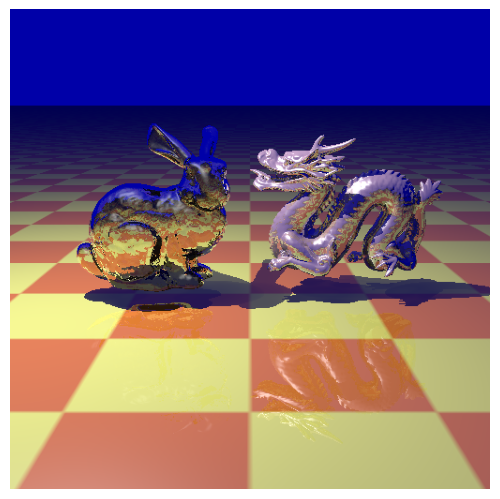

In [13]:
staging = vk.tensor(render_target.height, render_target.width, 4)
render_target.save(staging)
plt.imshow(staging.cpu() ** (1.0 / 2.2))
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

In [14]:
video_data = vk.tensor(100, SCREEN_HEIGHT, SCREEN_WIDTH, 3)  # 100 frames

In [15]:
for i in range(len(video_data)):
    alpha = i / len(video_data)
    look_at = vk.vec3(np.cos(alpha * 7), np.sin(alpha)*0.1 + 0.2, np.sin(alpha * 7))*(5 + np.sin(alpha))
    # we dont need to map because is permanently mapped and update is always CPU -> GPU
    with global_transform as b:
        b.View = vk.mat4.look_at(look_at, vk.vec3(0., 0., 0.), vk.vec3(0.,1., 0.))
    vk.submit(man)
    render_target.save(staging)
    video_data[i] = staging[...,:3]** (1.0 / 2.2)  # copy current frame to video (only RGB)
vk.save_video(video_data, 'teaser9.webp', 10, quality=100)

In [18]:
vk.notebook_show("teaser9.webp")